# K2-24

RadVel and exoplanet both have excellent tutorials where they fit for the two planets b and c of the K2-24 system. We will do the same here to show how to fit RV data in Ravest.

**Links:**  
K2-24 paper (Petigura et al 2016 ApJ 818 36): https://doi.org/10.3847/0004-637X/818/1/36  
RadVel tutorial: https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html  
exoplanet tutorial: https://gallery.exoplanet.codes/tutorials/rv/  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ravest.prior
from ravest.fit import Fitter
from ravest.model import calculate_mpsini
from ravest.param import Parameter, Parameterisation

Import the data

In [ ]:
url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, usecols=[1,2,3], names=["errvel", "time", "vel"], skiprows=1)
data

,errvel,time,vel
0,1.593725,2364.819580,6.959066
1,1.600745,2364.825101,5.017650
2,1.658815,2364.830703,13.811799
3,1.653224,2366.827579,1.151030
4,1.639095,2367.852646,9.389273
5,1.723691,2373.888150,-2.820614
6,1.907690,2374.852412,-0.772991
7,1.709263,2376.863820,-2.222920
8,1.838565,2377.866073,0.146115
9,1.649715,2378.834011,2.739558


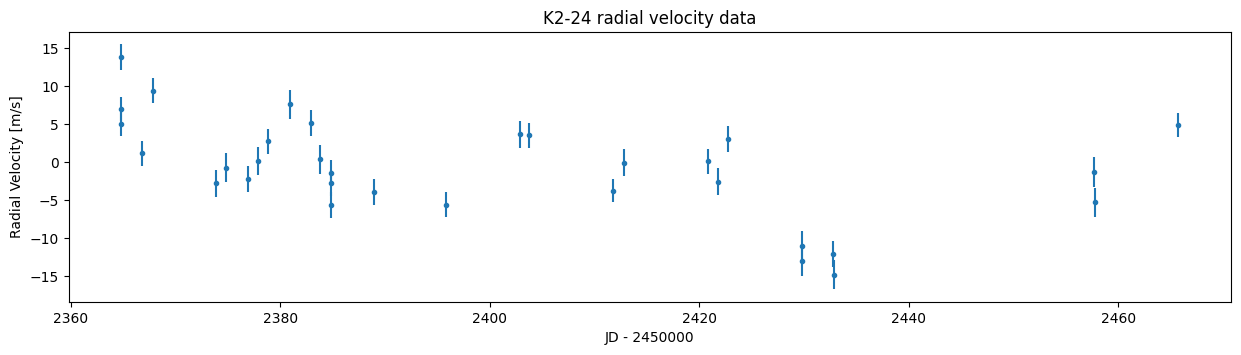

In [ ]:
plt.figure(figsize=(15,3.5))
plt.title("K2-24 radial velocity data")
plt.ylabel("Radial Velocity [m/s]")
plt.xlabel("JD - 2450000")
plt.errorbar(data["time"], data["vel"], yerr=data["errvel"], marker=".", linestyle="None")
plt.show()

Create a `Fitter` object, and choose which parameterisation to fit with, whether to fix or fit for each parameter, and the initial parameter values. We can fit a circular model by fixing eccentricity $e=0$ (the argument of periapsis $\omega_\star$ is now degenerate and can be fixed at any value, by convention we fix at $\pi/2$.) The reference zero-point time `t0` is used for linear and quadratic trends terms $\dot{\gamma}$ and $\ddot{\gamma}$.

In [ ]:
fitter = Fitter(planet_letters=["b","c"], parameterisation=Parameterisation("P K e w Tc"))
fitter.add_data(time=data["time"].to_numpy(), 
                vel=data["vel"].to_numpy(), 
                verr=data["errvel"].to_numpy(), 
                t0=2420)

# Construct the params dict
# These values will be used as your initial guess for the fit
params = {"P_b": Parameter(20.8853, "d", fixed=True),
          "K_b": Parameter(10, "m/s", fixed=False),
          "e_b": Parameter(0, "", fixed=True),
          "w_b": Parameter(np.pi/2, "rad", fixed=True),
          "Tc_b": Parameter(2072.7944, "d", fixed=True),

          "P_c": Parameter(42.3630, "d", fixed=True),
          "K_c": Parameter(10, "m/s", fixed=False),
          "e_c": Parameter(0, "", fixed=True),
          "w_c": Parameter(np.pi/2, "rad", fixed=True),
          "Tc_c": Parameter(2082.6252, "d", fixed=True),
          
          "g": Parameter(0, "m/s", fixed=False),
          "gd": Parameter(0, "m/s/day", fixed=False),
          "gdd": Parameter(0, "m/s/day^2", fixed=False),
          
          "jit": Parameter(0, "m/s", fixed=False),}

fitter.params = params
fitter.params

{'P_b': Parameter(value=20.8853, unit='d', fixed=True),
 'K_b': Parameter(value=10, unit='m/s', fixed=False),
 'e_b': Parameter(value=0, unit='', fixed=True),
 'w_b': Parameter(value=1.5707963267948966, unit='rad', fixed=True),
 'Tc_b': Parameter(value=2072.7944, unit='d', fixed=True),
 'P_c': Parameter(value=42.363, unit='d', fixed=True),
 'K_c': Parameter(value=10, unit='m/s', fixed=False),
 'e_c': Parameter(value=0, unit='', fixed=True),
 'w_c': Parameter(value=1.5707963267948966, unit='rad', fixed=True),
 'Tc_c': Parameter(value=2082.6252, unit='d', fixed=True),
 'g': Parameter(value=0, unit='m/s', fixed=False),
 'gd': Parameter(value=0, unit='m/s/day', fixed=False),
 'gdd': Parameter(value=0, unit='m/s/day^2', fixed=False),
 'jit': Parameter(value=0, unit='m/s', fixed=False)}

Define the prior functions for the free parameters. You can see a list of available prior functions at `ravest.prior.PRIOR_FUNCTIONS`.

In [ ]:
ravest.prior.PRIOR_FUNCTIONS

['Uniform',
 'EccentricityUniform',
 'Normal',
 'TruncatedNormal',
 'HalfNormal',
 'Rayleigh',
 'VanEylen19Mixture',
 'Beta']

In [ ]:
# Construct the priors dict. Every parameter that isn't fixed requires a prior.
priors = {
          "K_b": ravest.prior.Uniform(lower=0, upper=50),
          "K_c": ravest.prior.Uniform(lower=0, upper=50),

          "g": ravest.prior.Uniform(lower=-10, upper=10),
          "gd": ravest.prior.Uniform(lower=-0.1, upper=0.1),
          "gdd": ravest.prior.Uniform(lower=-0.01, upper=0.01),

          
          "jit": ravest.prior.Uniform(lower=0, upper=5),
         }

fitter.priors = priors
fitter.priors

{'K_b': Uniform(lower=0, upper=50),
 'K_c': Uniform(lower=0, upper=50),
 'g': Uniform(lower=-10, upper=10),
 'gd': Uniform(lower=-0.1, upper=0.1),
 'gdd': Uniform(lower=-0.01, upper=0.01),
 'jit': Uniform(lower=0, upper=5)}

Now that we have loaded the `Fitter` with the data, our parameterisation, our initial parameter values, and priors for each of the free parameters, we can now fit the free parameters of the model to the data.  
  
First, Maximum A Posteriori (MAP) optimisation is performed to find the best-fit solution.

In [ ]:
map_results = fitter.find_map_estimate(method="Powell")
map_results

MAP parameter results: {'K_b': 4.712029698141914, 'K_c': 3.9515473266645276, 'g': -4.008972876459954, 'gd': -0.030112135584878453, 'gdd': 0.0018133760186288413, 'jit': 2.7074075602429297}


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 89.67892452474888
       x: [ 4.712e+00  3.952e+00 -4.009e+00 -3.011e-02  1.813e-03
            2.707e+00]
     nit: 6
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 1.765e-01 -2.888e-01 ...  6.733e-04 -1.203e-01]]
    nfev: 370

Let's take a look at what the RV looks like with these parameter values:

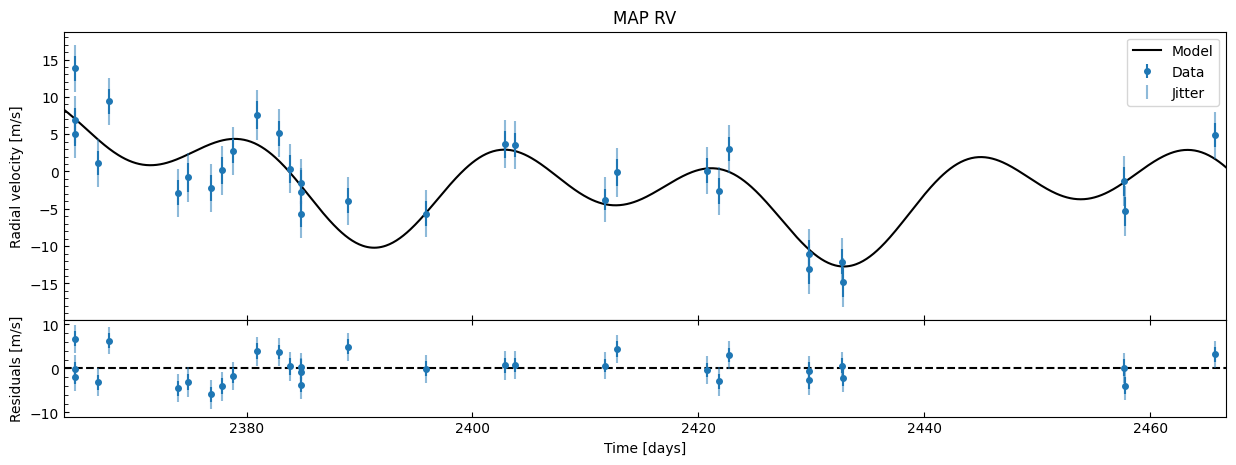

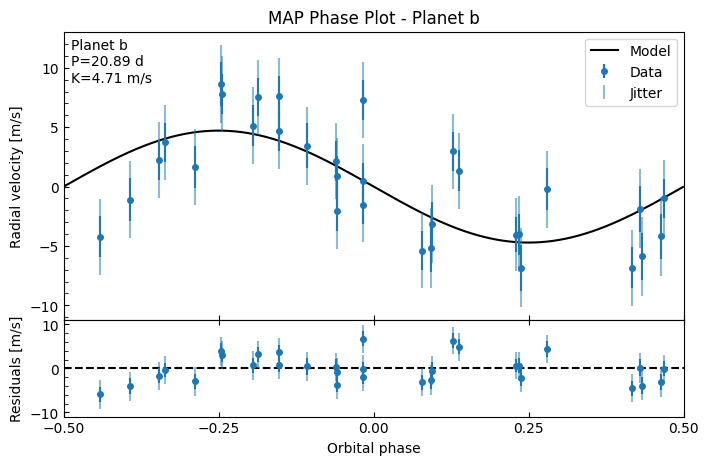

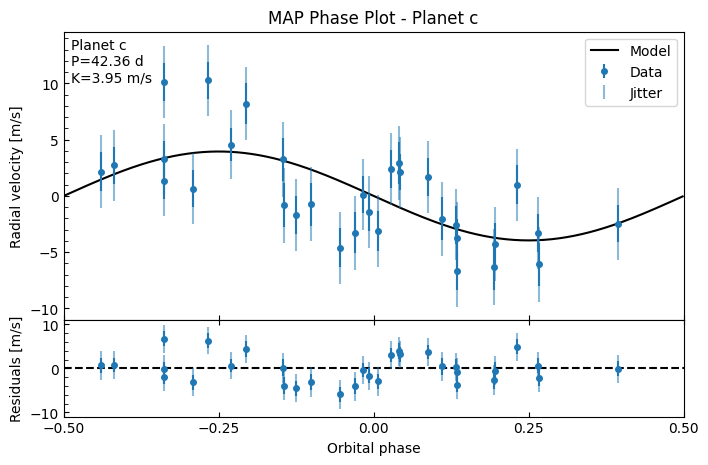

In [ ]:
fitter.plot_MAP_rv(map_result=map_results)
fitter.plot_MAP_phase(planet_letter="b", map_result=map_results)
fitter.plot_MAP_phase(planet_letter="c", map_result=map_results)

We can use MCMC to more fully explore the parameter space and estimate the parameter uncertainties. For the purposes of making this notebook run quickly, this is only running for 10000 steps - you should run considerably more. `ravest` enforces a minimum of at least 2 walkers per each free parameter, again though you should consider running more. You should also consider using randomly initialised starting points, rather than the MAP solution, to better explore the parameter space. Parallelisation has been (experimentally) enabled via the `multiprocessing` argument, this can result in significant speedups - especially for longer chains/more walkers.

In [ ]:
nwalkers = 20
mcmc_init = fitter.generate_initial_walker_positions_from_map(map_result=map_results, nwalkers=nwalkers, verbose=True)

Free parameters: ['K_b', 'K_c', 'g', 'gd', 'gdd', 'jit']
Centre values: [ 4.71202970e+00  3.95154733e+00 -4.00897288e+00 -3.01121356e-02
  1.81337602e-03  2.70740756e+00]
Centre point validated (log_prior = -6.907755278982138)
Walker 0 position: [ 4.71204842e+00  3.95114911e+00 -4.00916183e+00 -3.01134881e-02
  1.81331248e-03  2.70796759e+00] (valid after 1 attempts)
Walker 1 position: [ 4.71191597e+00  3.95177919e+00 -4.00864621e+00 -3.01184468e-02
  1.81339637e-03  2.70736511e+00] (valid after 1 attempts)
Walker 2 position: [ 4.71160353e+00  3.95110250e+00 -4.00831161e+00 -3.01140153e-02
  1.81363014e-03  2.70726930e+00] (valid after 1 attempts)
Walker 3 position: [ 4.71106392e+00  3.95162633e+00 -4.00947368e+00 -3.01107158e-02
  1.81335284e-03  2.70750995e+00] (valid after 1 attempts)
Walker 4 position: [ 4.71214239e+00  3.95217592e+00 -4.00845912e+00 -3.01112734e-02
  1.81345544e-03  2.70686965e+00] (valid after 1 attempts)
Walker 5 position: [ 4.71199870e+00  3.95162817e+00 -4.009

In [ ]:
nsteps = 11_000

# Fit the free parameters to the data. Use the MAP solution as the initial value for the MCMC walkers.
fitter.run_mcmc(initial_positions=mcmc_init, nwalkers=nwalkers, max_steps=nsteps, progress=True, multiprocessing=True)  # This will take a few minutes!

INFO:root:Starting MCMC for 11000 steps...
100%|██████████| 11000/11000 [00:14<00:00, 772.57it/s]
INFO:root:...MCMC done.


Now that the MCMC is finished, the state of the `emcee` sampler has been saved into the `Fitter` object. We can therefore export the posterior samples, as a `numpy` array that can be passed into other functions (such as for comparing two models by calculating the Bayesian evidence - example notebook coming soon!). We can also export them into a Pandas dataframe, which keeps each parameter labelled. In both cases, we can pass in the `discard_start` and `discard_end` arguments, to drop the burn-in or "zoom" in on certain areas of the chain by discarding other parts. The `thin` argument keeps only every `thin`-th sample, and the `flat` argument combines all of the different walkers for each parameter into one long chain per parameter.

In [ ]:
nburn = 1_000
thin_rate = 10

# Get the samples as a numpy array
samples = fitter.get_samples_np(discard_start=nburn, discard_end=0, thin=thin_rate, flat=False) # shape (nsteps, nwalkers, ndim)

# Get the samples as a labelled Pandas dataframe
samples_df = fitter.get_samples_df(discard_start=nburn, discard_end=0, thin=thin_rate)  # shape (nsteps*nwalkers, ndim)
samples_df

,K_b,K_c,g,gd,gdd,jit
0,5.268332,3.662170,-4.871786,-0.035349,0.002138,2.347638
1,5.501178,3.880377,-3.670551,-0.022983,0.001617,3.346788
2,5.096572,3.196162,-1.116463,-0.047189,0.000573,3.595268
3,5.235369,3.826489,-4.610360,0.003435,0.002194,3.289012
4,4.511646,5.489138,-2.894724,-0.067648,0.000748,3.855102
...,...,...,...,...,...,...
19995,4.486927,4.326356,-3.830381,0.005603,0.001845,2.426073
19996,5.422236,1.969776,-5.652021,-0.034529,0.002220,3.441109
19997,4.256794,4.700272,-1.940487,-0.008475,0.001308,3.662358
19998,3.459257,2.903425,-3.003236,-0.016716,0.002186,3.177493


To inspect the chains visually, we can plot (and optionally save) the time series of each parameter in the chain. We see that after a brief period aorund the initial values (which we expect, as we started the walkers at the MAP values, so they'll be starting at an area of maximised likelihood), they eventually break out and start exploring the parameter space more. For all future plots we can discard this initial "burn-in" with the `discard_start` argument.

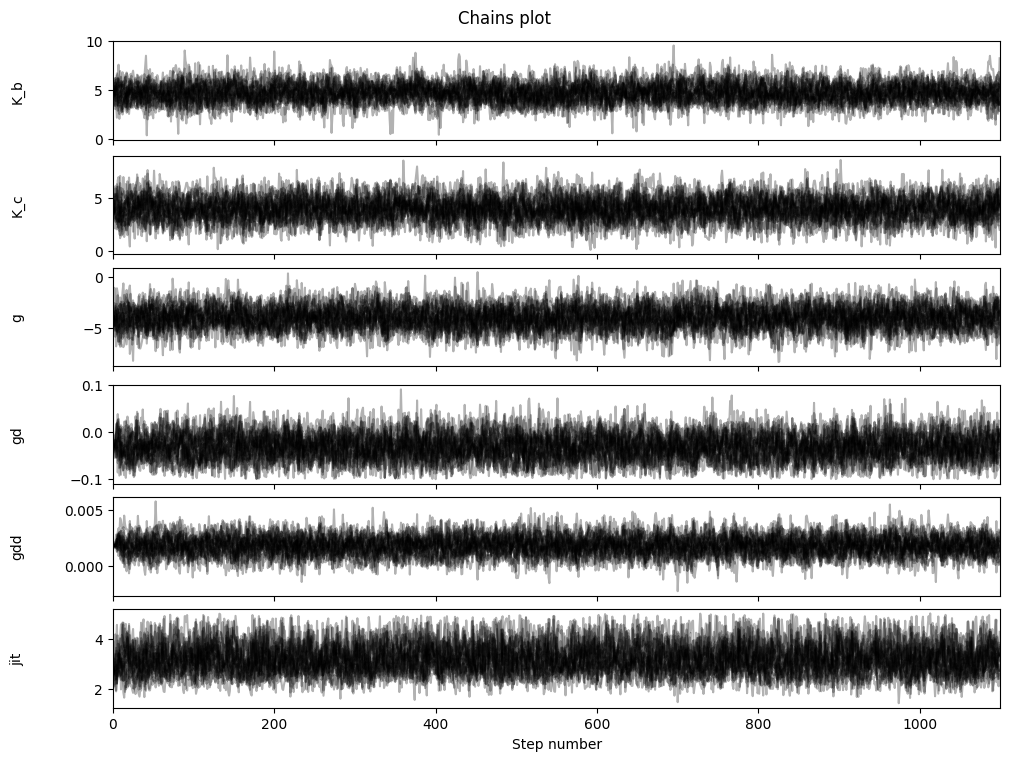

In [ ]:
fitter.plot_chains(discard_start=0, discard_end=0, thin=thin_rate, save=False)

We can visualise the posterior parameter distributions in corner plots, using the `corner` module.

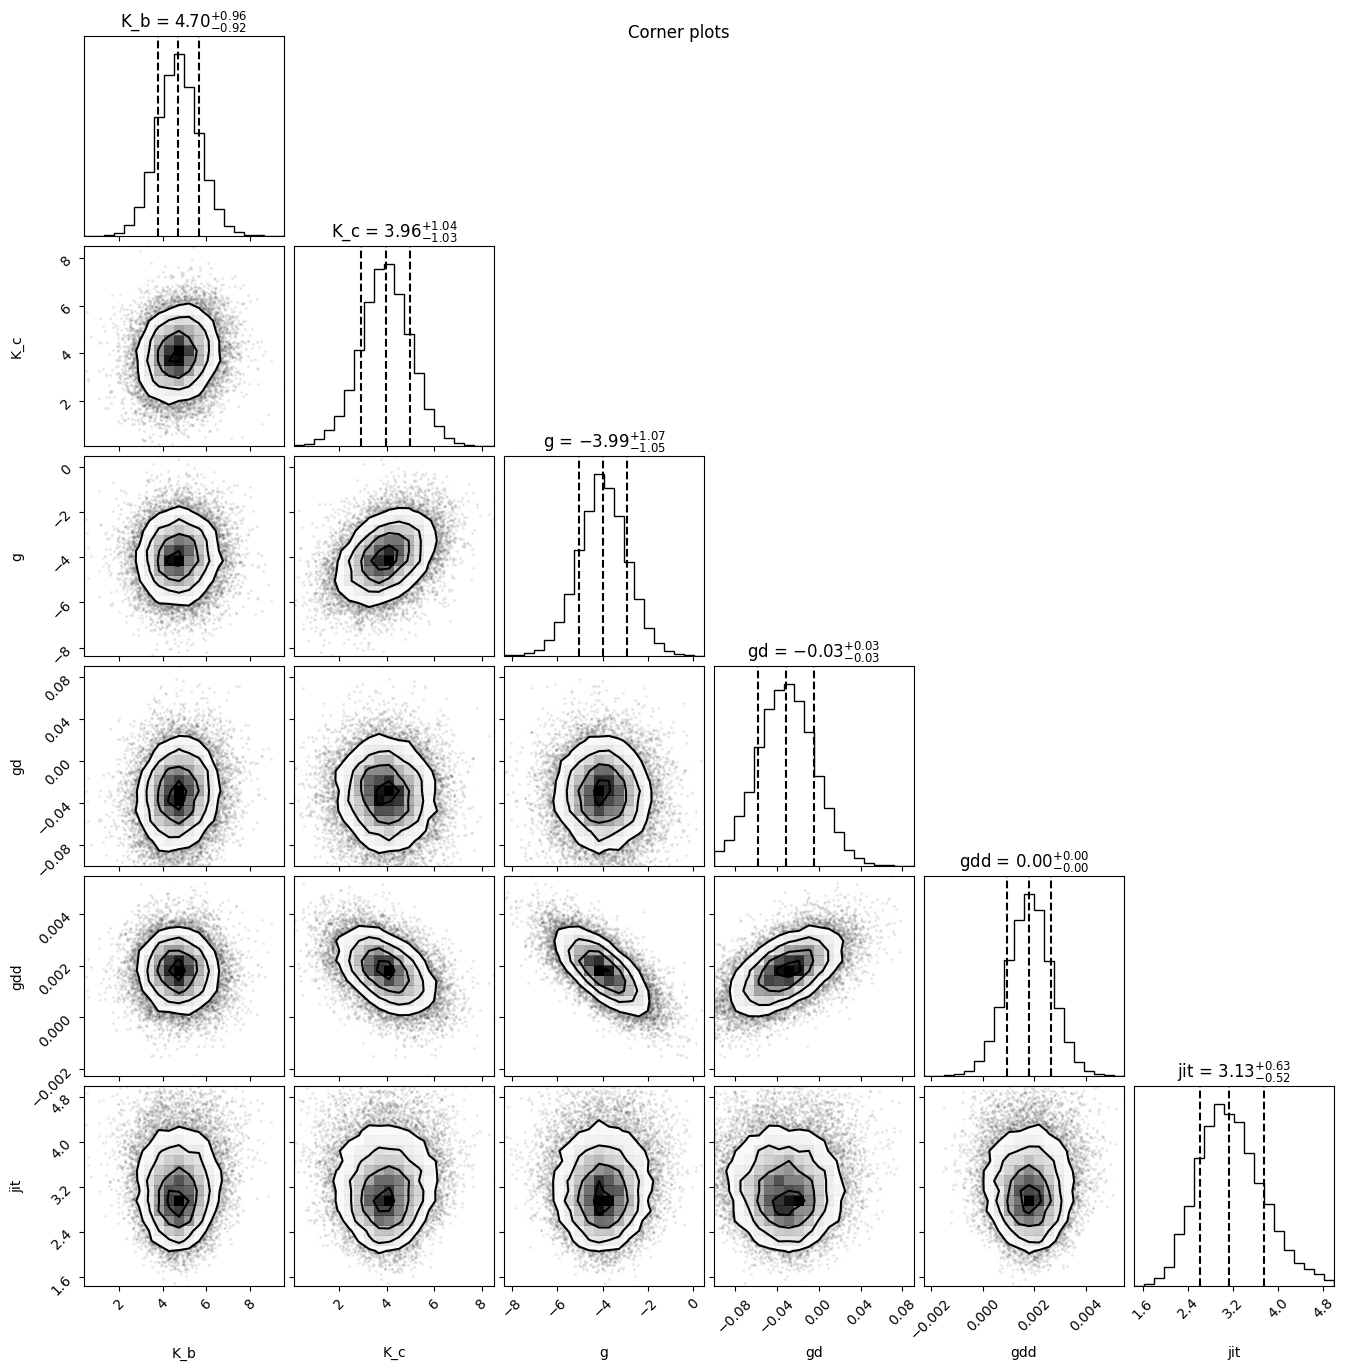

In [ ]:
fitter.plot_corner(discard_start=nburn, discard_end=0, thin=thin_rate, plot_datapoints=True, save=False)

Inspecting the posteriors, we can see the 16th, 50th and 84th percentiles are shown, which could be used for a quoted value and uncertainty. It's a good idea to inspect the posterior distribution visually with the corner plots though, as they may not always be nice Gaussians, which means those percentiles may not be a good representation. (This is often the case for eccentricity!). For further analysis and inspection, recall that we can get a dataframe of the samples (e.g. to plot them in a histogram to inspect the distribution closer) by using the `Fitter.get_samples_df()` method that we saw earlier.

Let's see what the posterior RV looks like - we'll calcuate the RV for each of the MCMC samples, plot the median RV and 16-84 percentiles at each timestep. We'll also look at each planet's contribution in isolation with phase plots.

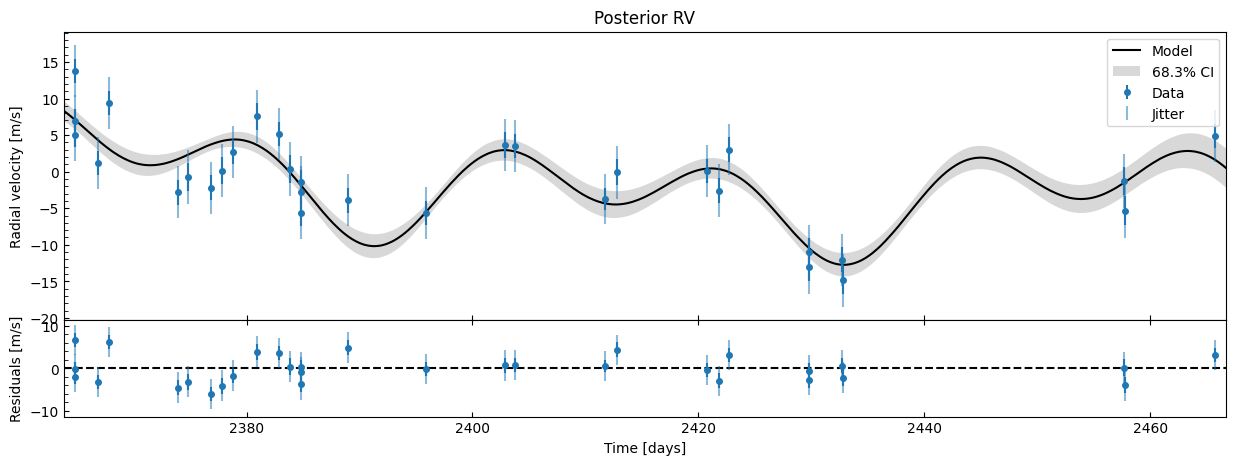

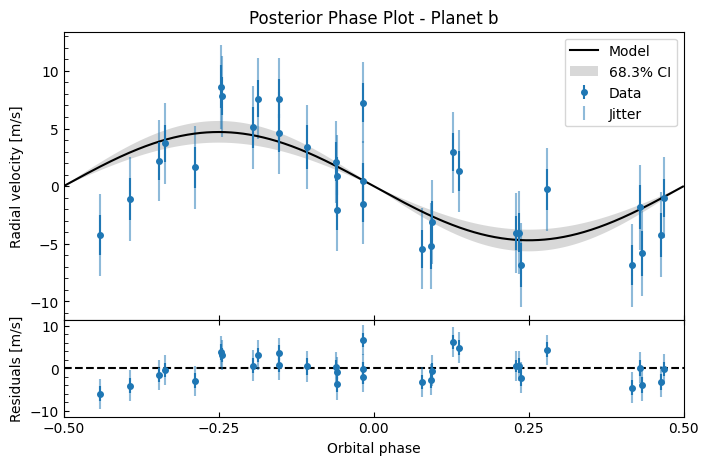

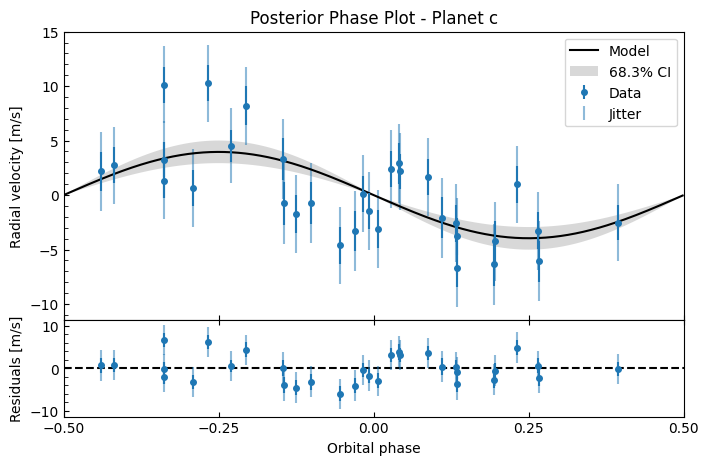

In [ ]:
fitter.plot_posterior_rv(discard_start=nburn, discard_end=0, thin=thin_rate)
fitter.plot_posterior_phase("b", discard_start=nburn, discard_end=0, thin=thin_rate)
fitter.plot_posterior_phase("c", discard_start=nburn, discard_end=0, thin=thin_rate)

To calculate planetary mass estimates $M_p\sin{i}$, we need to know the stellar mass. Using the value $M_\star=1.12\pm0.05$ used in Petigura et al. 2016, we can generate a distribution of stellar mass values from the published value and uncertainty, and draw from that distribution to use as the value of $M_\star$ in the conversion equation.

In [ ]:
# Stellar mass values from Petigura et al. 2016
mstar_val = 1.12  # [M_sun]
mstar_err = 0.05 # [M_sun]

# Create a distribution of stellar mass values from the published value and uncertainty
np.random.seed(47)  # For reproducibility
mstar = np.random.normal(loc=mstar_val, scale=mstar_err, size=len(samples_df))
# Ensure all values in mstar are positive (incredibly unlikely to be an issue with these values, but just in case)
while any(mstar <= 0):
    mstar[mstar <= 0] = np.random.normal(loc=mstar_val, scale=mstar_err, size=sum(mstar <= 0))

Planet b Mpsin(i): 21.798086086148917 + 4.283701120593335 - 4.49584787737755
Planet c Mpsin(i): 23.23198751982098 + 5.989914871947665 - 6.159652313518119


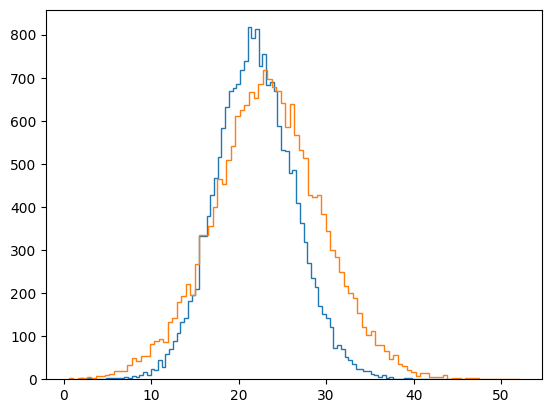

In [ ]:
# get the posterior samples (both free and fixed) as a dictionary
posterior_params = fitter.get_mcmc_posterior_dict(discard_start=nburn, discard_end=0, thin=thin_rate)  # get the fixed value for fixed parameters, get the MCMC samples for the free parameters

# use the MCMC samples and the stellar mass distribution to get a distribution for Mp sin(i)
mpsini_b = calculate_mpsini(mstar, posterior_params["P_b"], posterior_params["K_b"], posterior_params["e_b"], unit="M_earth")
mpsini_c = calculate_mpsini(mstar, posterior_params["P_c"], posterior_params["K_c"], posterior_params["e_c"], unit="M_earth")

# calculate the median and 1-sigma uncertainties
perc_b = np.percentile(mpsini_b, [16, 50, 84])
perc_c = np.percentile(mpsini_c, [16, 50, 84])
print("Planet b Mpsin(i):", perc_b[1], "+", perc_b[1] - perc_b[0], "-", perc_b[2] - perc_b[1])
print("Planet c Mpsin(i):", perc_c[1], "+", perc_c[1] - perc_c[0], "-", perc_c[2] - perc_c[1])

# Plot the mass posteriors for inspection
plt.hist(mpsini_b, bins=100, histtype="step")
plt.hist(mpsini_c, bins=100, histtype="step")

plt.show()

---

## Eccentric orbits

Let's make a new `Fitter` object and fit for eccentricity. We'll fit in the $\sqrt{e}\cos{\omega_\star}$ and $\sqrt{e}\sin{\omega_\star}$ parameterisation.

In [ ]:
# Fit in the sqrt(e) parameterisation
parameterisation_se = Parameterisation("P K secosw sesinw Tc")

fitter_se = Fitter(planet_letters=["b","c"], parameterisation=parameterisation_se)
fitter_se.add_data(time=data["time"].to_numpy(), 
                   vel=data["vel"].to_numpy(), 
                   verr=data["errvel"].to_numpy(), 
                   t0=2420)
print(fitter_se.t0)

# Construct the params dict
# These values will be used as your initial guess for the fit
params_se = {"P_b": Parameter(20.8853, "d", fixed=True),
            "K_b": Parameter(np.exp(1.55037), "m/s", fixed=False),
            "secosw_b": Parameter(0.01, "", fixed=False),
            "sesinw_b": Parameter(0.01, "", fixed=False),
            "Tc_b": Parameter(2072.7944, "d", fixed=True),

            "P_c": Parameter(42.3630, "d", fixed=True),
            "K_c": Parameter(np.exp(1.37648), "m/s", fixed=False),
            "secosw_c": Parameter(0.01, "", fixed=False),
            "sesinw_c": Parameter(0.01, "", fixed=False),
            "Tc_c": Parameter(2082.6252, "d", fixed=True),
            
            "g": Parameter(-3.99195, "m/s", fixed=False),
            "gd": Parameter(0, "m/s/day", fixed=False),
            "gdd": Parameter(0, "m/s/day^2", fixed=False),

            "jit": Parameter(2.09753, "m/s", fixed=False),
            }

fitter_se.params = params_se
fitter_se.params

2420


{'P_b': Parameter(value=20.8853, unit='d', fixed=True),
 'K_b': Parameter(value=4.7132137490982124, unit='m/s', fixed=False),
 'secosw_b': Parameter(value=0.01, unit='', fixed=False),
 'sesinw_b': Parameter(value=0.01, unit='', fixed=False),
 'Tc_b': Parameter(value=2072.7944, unit='d', fixed=True),
 'P_c': Parameter(value=42.363, unit='d', fixed=True),
 'K_c': Parameter(value=3.9609345702082397, unit='m/s', fixed=False),
 'secosw_c': Parameter(value=0.01, unit='', fixed=False),
 'sesinw_c': Parameter(value=0.01, unit='', fixed=False),
 'Tc_c': Parameter(value=2082.6252, unit='d', fixed=True),
 'g': Parameter(value=-3.99195, unit='m/s', fixed=False),
 'gd': Parameter(value=0, unit='m/s/day', fixed=False),
 'gdd': Parameter(value=0, unit='m/s/day^2', fixed=False),
 'jit': Parameter(value=2.09753, unit='m/s', fixed=False)}

We could put `Uniform`  priors on the $\sqrt{e}\cos{\omega_\star}$ and $\sqrt{e}\sin{\omega_\star}$ parameters directly, but here we'll show how you can also put priors on their equivalent parameters ($e$ and $\omega_\star$) from the default parameterisation ($P, K, e, \omega_\star, T_c$) too. Note the use of `EccentricityUniform` which allows $e=0$ exactly, whereas a standard `Uniform` prior is closed-interval and won't allow $e=0$ exactly.

In [ ]:
# Construct the priors dict. Every parameter that isn't fixed requires a prior.
priors_se = {
          "K_b": ravest.prior.Uniform(lower=0, upper=50),
          "e_b": ravest.prior.EccentricityUniform(upper=0.8),     # Prior on e & w, even though fitting in secosw sesinw
          "w_b": ravest.prior.Uniform(lower=-np.pi, upper=np.pi),

          "K_c": ravest.prior.Uniform(lower=0, upper=50),
          "e_c": ravest.prior.EccentricityUniform(upper=0.8),     # Prior on e & w, even though fitting in secosw sesinw
          "w_c": ravest.prior.Uniform(lower=-np.pi, upper=np.pi),

          "g": ravest.prior.Uniform(lower=-10, upper=10),
          "gd": ravest.prior.Uniform(lower=-0.1, upper=0.1),
          "gdd": ravest.prior.Uniform(lower=-0.01, upper=0.01),
          
          "jit": ravest.prior.Uniform(lower=0, upper=5),
        }

fitter_se.priors = priors_se
fitter_se.priors

{'K_b': Uniform(lower=0, upper=50),
 'e_b': EccentricityUniform(upper=0.8),
 'w_b': Uniform(lower=-3.141592653589793, upper=3.141592653589793),
 'K_c': Uniform(lower=0, upper=50),
 'e_c': EccentricityUniform(upper=0.8),
 'w_c': Uniform(lower=-3.141592653589793, upper=3.141592653589793),
 'g': Uniform(lower=-10, upper=10),
 'gd': Uniform(lower=-0.1, upper=0.1),
 'gdd': Uniform(lower=-0.01, upper=0.01),
 'jit': Uniform(lower=0, upper=5)}

In [ ]:
map_results_se = fitter_se.find_map_estimate(method="Powell")
map_results_se

MAP parameter results: {'K_b': 6.0912170450776495, 'secosw_b': 0.38953427087089126, 'sesinw_b': -0.4217350138510508, 'K_c': 4.36016598045971, 'secosw_c': -0.13122587459729435, 'sesinw_c': 0.363516059928289, 'g': -4.567179915373858, 'gd': -0.030223243050356684, 'gdd': 0.002085547195680399, 'jit': 1.9482056974721567}


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 86.03768368718983
       x: [ 6.091e+00  3.895e-01 -4.217e-01  4.360e+00 -1.312e-01
            3.635e-01 -4.567e+00 -3.022e-02  2.086e-03  1.948e+00]
     nit: 10
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [-8.368e-02 -1.924e-03 ...  1.142e-04  8.957e-03]]
    nfev: 1115

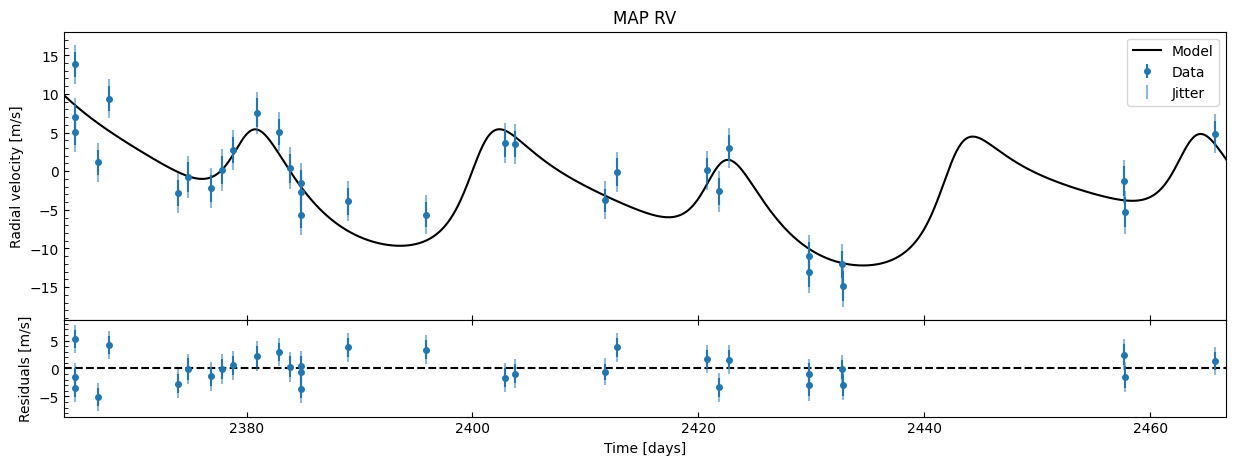

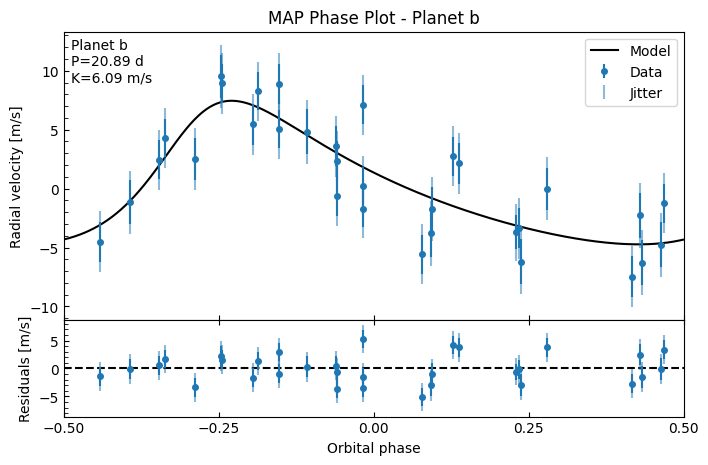

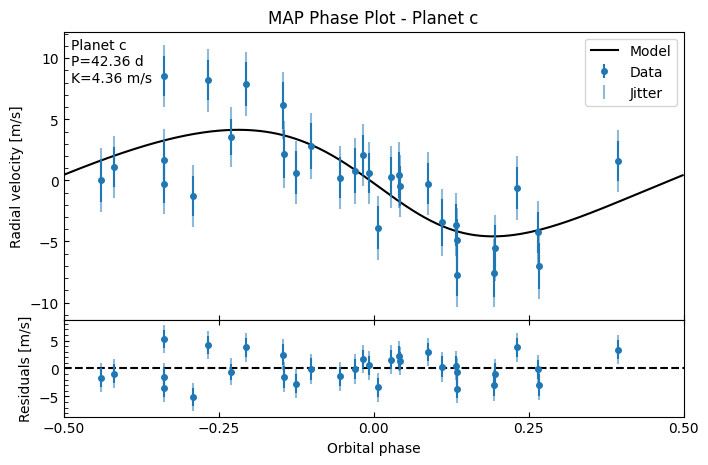

In [ ]:
fitter_se.plot_MAP_rv(map_result=map_results_se)
fitter_se.plot_MAP_phase(planet_letter="b", map_result=map_results_se)
fitter_se.plot_MAP_phase(planet_letter="c", map_result=map_results_se)

We can already see that the residuals are generally tighter than they were in the circular case.

In [ ]:
nwalkers_se = 20
mcmc_init_se = fitter_se.generate_initial_walker_positions_from_map(map_result=map_results_se, nwalkers=nwalkers_se, verbose=True)

Free parameters: ['K_b', 'secosw_b', 'sesinw_b', 'K_c', 'secosw_c', 'sesinw_c', 'g', 'gd', 'gdd', 'jit']
Centre values: [ 6.09121705e+00  3.89534271e-01 -4.21735014e-01  4.36016598e+00
 -1.31225875e-01  3.63516060e-01 -4.56717992e+00 -3.02232431e-02
  2.08554720e-03  1.94820570e+00]
Centre point validated (log_prior = -10.137222309172408)
Walker 0 position: [ 6.09131718e+00  3.89543026e-01 -4.21883290e-01  4.36034929e+00
 -1.31230795e-01  3.63528326e-01 -4.56736734e+00 -3.02226383e-02
  2.08561025e-03  1.94798656e+00] (valid after 1 attempts)
Walker 1 position: [ 6.09034697e+00  3.89508347e-01 -4.21684986e-01  4.35991784e+00
 -1.31216420e-01  3.63455324e-01 -4.56756282e+00 -3.02184667e-02
  2.08539009e-03  1.94807020e+00] (valid after 1 attempts)
Walker 2 position: [ 6.09125778e+00  3.89599959e-01 -4.21687798e-01  4.36025404e+00
 -1.31215671e-01  3.63508808e-01 -4.56736679e+00 -3.02264981e-02
  2.08542462e-03  1.94838164e+00] (valid after 1 attempts)
Walker 3 position: [ 6.09062525e+00

In [ ]:
nsteps = 11_000

# Fit the free parameters to the data
samples_se = fitter_se.run_mcmc(initial_positions=mcmc_init_se, nwalkers=nwalkers_se, max_steps=nsteps, progress=True, multiprocessing=True)  # This will take a while!

INFO:root:Starting MCMC for 11000 steps...
100%|██████████| 11000/11000 [00:20<00:00, 544.15it/s]
INFO:root:...MCMC done.


In [ ]:
# Get the samples as a numpy array
samples_se = fitter_se.get_samples_np(discard_start=nburn, discard_end=0, thin=thin_rate, flat=False) # shape (nsteps, nwalkers, ndim)

# Get the samples as a labelled Pandas dataframe
samples_df_se = fitter_se.get_samples_df(discard_start=nburn, discard_end=0, thin=thin_rate)  # shape (nsteps*nwalkers, ndim)
samples_df_se

,K_b,secosw_b,sesinw_b,K_c,secosw_c,sesinw_c,g,gd,gdd,jit
0,4.276151,0.426291,-0.438663,4.234029,-0.299408,-0.115579,-4.740009,-0.046416,0.002147,3.047270
1,6.548703,0.485535,0.077619,5.978530,0.389175,-0.296649,-3.891968,-0.038365,0.000129,3.643884
2,5.812652,0.248510,-0.403389,3.457636,0.112676,-0.034671,-5.654597,-0.034267,0.002476,2.245252
3,5.049782,0.366184,-0.388658,3.060960,-0.269598,-0.236240,-6.359627,-0.038956,0.003585,2.958553
4,7.456244,0.488994,-0.287324,4.937372,0.087867,0.542340,-4.512295,-0.037840,0.001433,1.914770
...,...,...,...,...,...,...,...,...,...,...
19995,6.455747,0.437306,0.282246,3.980501,-0.305535,-0.056727,-3.941618,-0.045244,0.001281,3.087095
19996,5.111706,0.368293,-0.419975,4.319631,-0.322891,0.174608,-5.361796,-0.016697,0.003198,2.352868
19997,5.423229,0.499683,-0.125235,3.116799,0.261740,-0.182661,-5.061289,-0.083560,0.001807,3.074203
19998,5.659583,0.395126,-0.393494,5.026808,-0.094270,-0.433582,-4.661309,0.024594,0.002577,2.729452


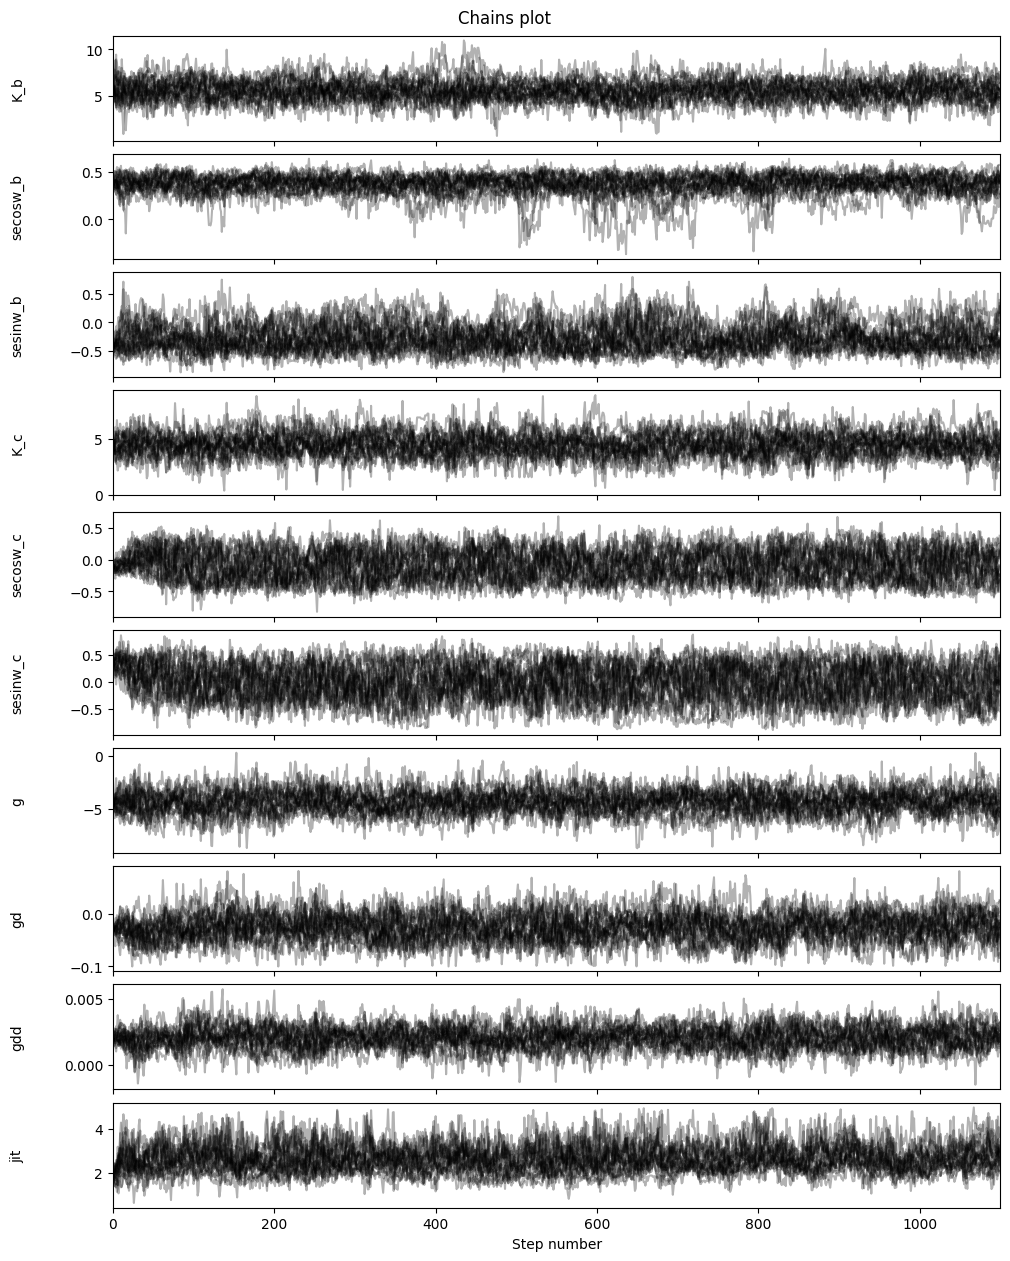

In [ ]:
fitter_se.plot_chains(discard_start=0, discard_end=0, thin=thin_rate, save=False)

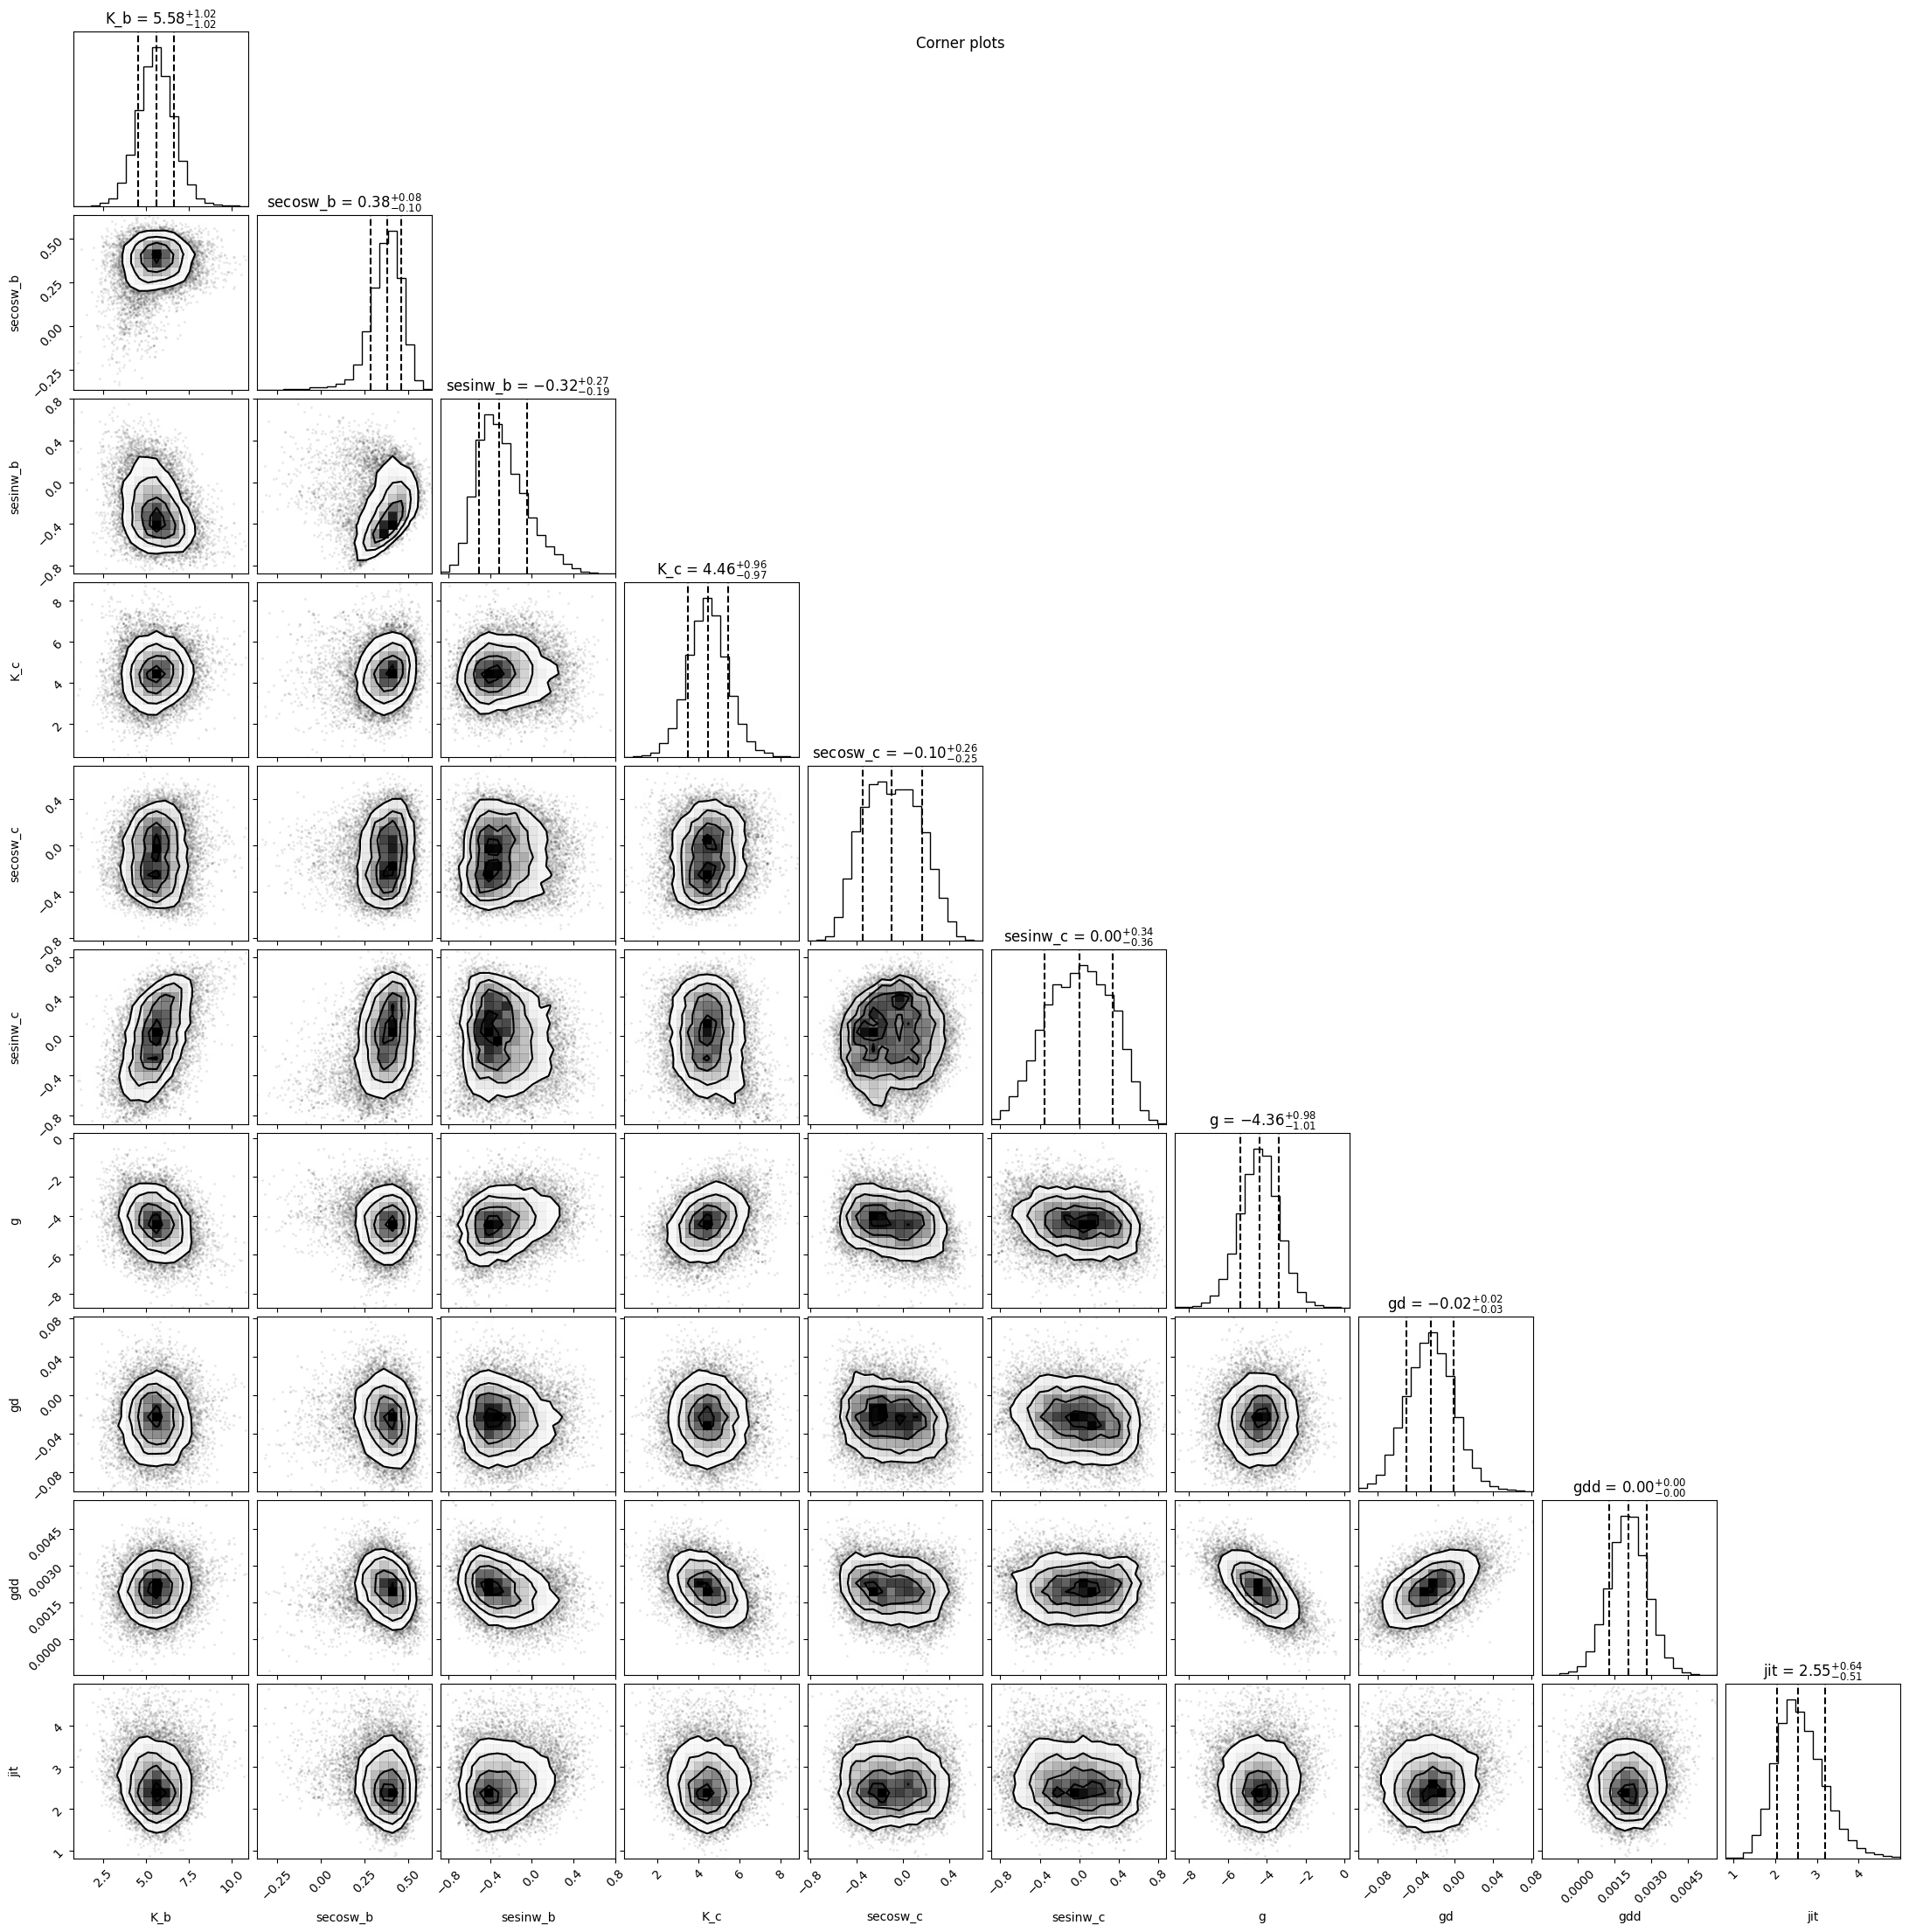

In [ ]:
fitter_se.plot_corner(discard_start=nburn, discard_end=0, thin=thin_rate, plot_datapoints=True, save=False)

We can convert $\sqrt{e}\cos{\omega_\star}$ and $\sqrt{e}\sin{\omega_\star}$ chains back to $e$ (and $\omega_\star$) to inspect the posterior eccentricity directly.

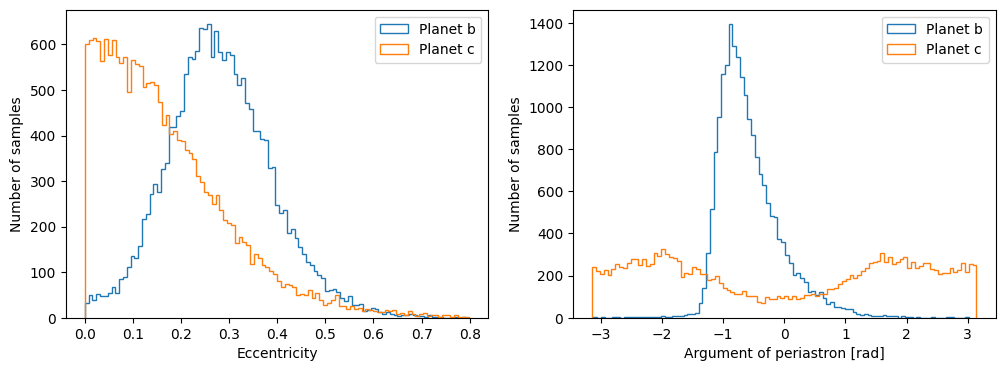

In [ ]:
eb_array, wb_array = parameterisation_se.convert_secosw_sesinw_to_e_w(samples_df_se["secosw_b"], samples_df_se["sesinw_b"])
ec_array, wc_array = parameterisation_se.convert_secosw_sesinw_to_e_w(samples_df_se["secosw_c"], samples_df_se["sesinw_c"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(eb_array, bins=100, histtype="step", label="Planet b")
ax1.hist(ec_array, bins=100, histtype="step", label="Planet c")

ax1.legend()
ax1.set_xlabel("Eccentricity")
ax1.set_ylabel("Number of samples")

ax2.hist(wb_array, bins=100, histtype="step", label="Planet b")
ax2.hist(wc_array, bins=100, histtype="step", label="Planet c")
ax2.legend()
ax2.set_xlabel("Argument of periastron [rad]")
ax2.set_ylabel("Number of samples")
plt.show()

Planet b definitely looks eccentric, harder to tell for planet c though. (Remember $\omega_\star$ becomes undefined when $e=0$, which might explain why $\omega_{\star,c}$ has such a wide spread: because a lot of the samples are where $e_c$ is close to 0, walkers making large moves in $\omega_{\star,c}$ will have little effect on the resultant RV. So with an uninformative prior, the walker will just explore through the entire parameter space for $\omega_{\star,c}$ without much effect on the log-likelihood).

Let's inspect how well our models matches the observed RV data. These functions evaluate the RV for every sample in the chains (after discarding and thinning), and plots the median and 68.3% interval of the RV at every timestep. (N.B. thinning can be useful here - these plots can take a while to generate as it has to calculate the RV curve for every sample in the chain.)

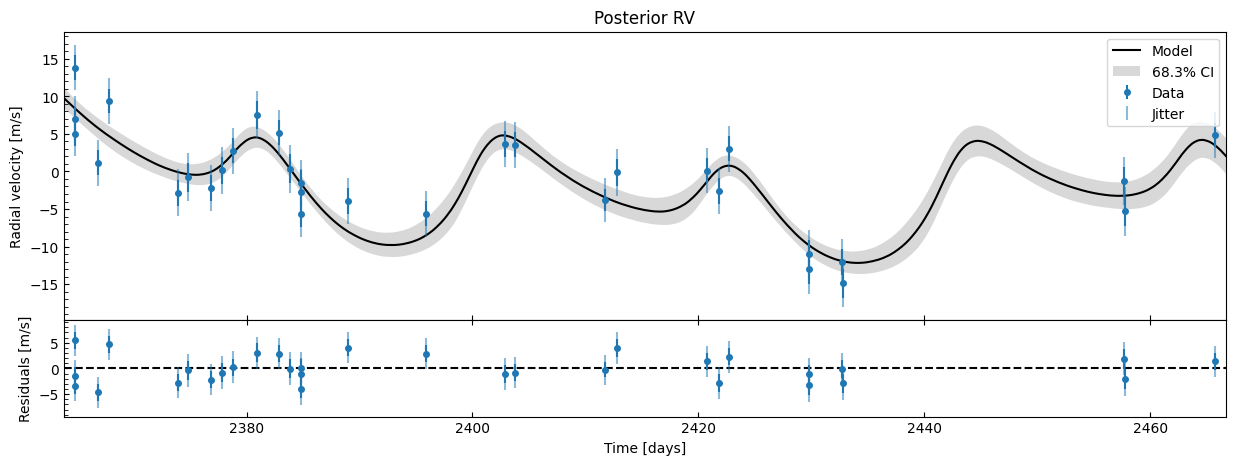

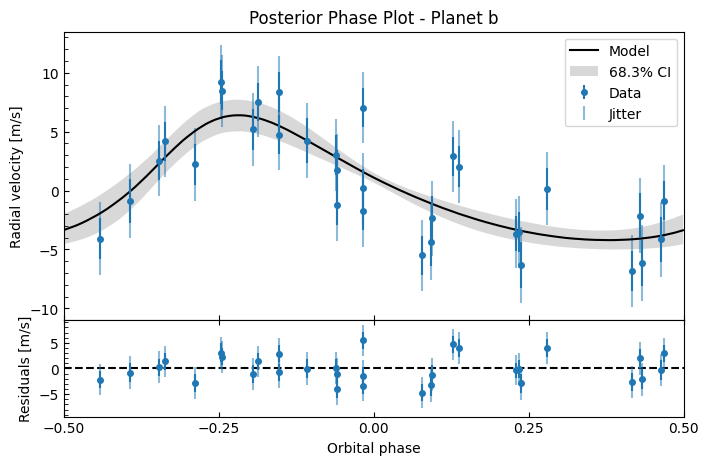

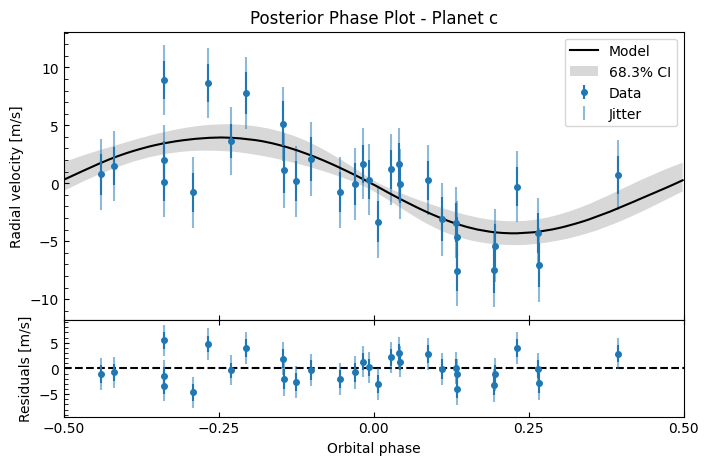

In [ ]:
fitter_se.plot_posterior_rv(discard_start=nburn, discard_end=0, thin=thin_rate)
fitter_se.plot_posterior_phase("b", discard_start=nburn, discard_end=0, thin=thin_rate)
fitter_se.plot_posterior_phase("c", discard_start=nburn, discard_end=0, thin=thin_rate)

Let's see how allowing for eccentric orbits affects the mass estimates $M_p\sin{i}$. We will use the same stellar mass values from Petigura et al. 2016 that we used earlier.

In [ ]:
# Create a distribution of stellar mass values using the same published value and uncertainty as before
np.random.seed(47)  # For reproducibility
mstar = np.random.normal(loc=mstar_val, scale=mstar_err, size=len(samples_df_se))
# Ensure all values in mstar are positive (incredibly unlikely to be an issue with these values, but just in case)
while any(mstar <= 0):
    print(mstar[mstar <= 0])
    mstar[mstar <= 0] = np.random.normal(loc=mstar_val, scale=mstar_err, size=sum(mstar <= 0))

Planet b Mpsin(i): 24.64671879761454 + 4.455044281487989 - 4.368555425282441
Planet c Mpsin(i): 25.58046099128044 + 5.568407480038388 - 5.473349594249999


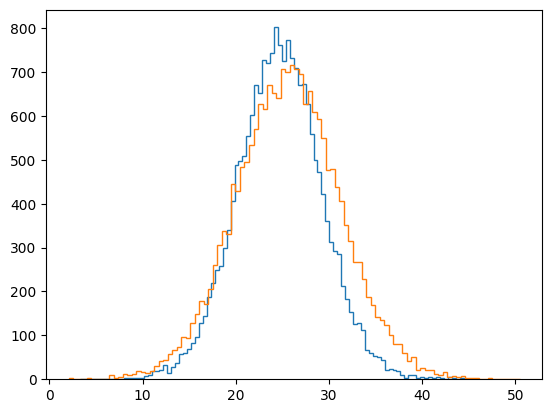

In [ ]:
# get the posterior samples (both free and fixed) as a dictionary
posterior_params_se = fitter_se.get_mcmc_posterior_dict(discard_start=nburn, discard_end=0, thin=thin_rate)  # get the fixed value for fixed parameters, get the MCMC samples for the free parameters

# we need to convert secosw and sesinw to e and w
# let's do this using the parameterisation class, parameterisation_se
posterior_params_se["e_b"], posterior_params_se["w_b"] = parameterisation_se.convert_secosw_sesinw_to_e_w(posterior_params_se["secosw_b"], posterior_params_se["sesinw_b"])
# and the same for _c
posterior_params_se["e_c"], posterior_params_se["w_c"] = parameterisation_se.convert_secosw_sesinw_to_e_w(posterior_params_se["secosw_c"], posterior_params_se["sesinw_c"])


# use the MCMC samples and the stellar mass distribution to get a distribution for Mp sin(i)

mpsini_b_se = calculate_mpsini(mstar, posterior_params_se["P_b"], posterior_params_se["K_b"], posterior_params_se["e_b"], unit="M_earth")
mpsini_c_se = calculate_mpsini(mstar, posterior_params_se["P_c"], posterior_params_se["K_c"], posterior_params_se["e_c"], unit="M_earth")

# calculate the median and 1-sigma uncertainties
perc_b_se = np.percentile(mpsini_b_se, [16, 50, 84])
perc_c_se = np.percentile(mpsini_c_se, [16, 50, 84])
print("Planet b Mpsin(i):", perc_b_se[1], "+", perc_b_se[1] - perc_b_se[0], "-", perc_b_se[2] - perc_b_se[1])
print("Planet c Mpsin(i):", perc_c_se[1], "+", perc_c_se[1] - perc_c_se[0], "-", perc_c_se[2] - perc_c_se[1])

# Plot the mass posteriors for inspection
plt.hist(mpsini_b_se, bins=100, histtype="step")
plt.hist(mpsini_c_se, bins=100, histtype="step")
plt.show()

---

# Model Comparison

Now let's compare the circular and eccentric models quantitatively using statistical metrics.

In [ ]:
# Calculate metrics for circular model
fitter_samples = fitter.get_samples_np(discard_start=nburn, discard_end=0, thin=thin_rate, flat=True)
fitter_medians = np.percentile(fitter_samples, 50, axis=0)
fitter_complete_dict = fitter.build_params_dict(fitter_medians)

fitter_chi2 = fitter.calculate_chi2(fitter_complete_dict)
fitter_loglike = fitter.calculate_log_likelihood(fitter_complete_dict)
fitter_aic = fitter.calculate_aic(fitter_complete_dict)
fitter_bic = fitter.calculate_bic(fitter_complete_dict)

print("Circular model metrics at 50th percentile:")
print(f"  Chi2:          {fitter_chi2:.2f}")
print(f"  Log-likelihood: {fitter_loglike:.2f}")
print(f"  AIC:            {fitter_aic:.2f}")
print(f"  BIC:            {fitter_bic:.2f}")

Circular model metrics at 50th percentile:
  Chi2:          25.74
  Log-likelihood: -83.12
  AIC:            178.24
  BIC:            187.03


In [ ]:
# Calculate metrics for eccentric model
fitter_se_samples = fitter_se.get_samples_np(discard_start=nburn, discard_end=0, thin=thin_rate, flat=True)
fitter_se_medians = np.percentile(fitter_se_samples, 50, axis=0)
fitter_se_complete_dict = fitter_se.build_params_dict(fitter_se_medians)

fitter_se_chi2 = fitter_se.calculate_chi2(fitter_se_complete_dict)
fitter_se_loglike = fitter_se.calculate_log_likelihood(fitter_se_complete_dict)
fitter_se_aic = fitter_se.calculate_aic(fitter_se_complete_dict)
fitter_se_bic = fitter_se.calculate_bic(fitter_se_complete_dict)

print("Eccentric model metrics at 50th percentile:")
print(f"  Chi2:          {fitter_se_chi2:.2f}")
print(f"  Log-likelihood: {fitter_se_loglike:.2f}")
print(f"  AIC:            {fitter_se_aic:.2f}")
print(f"  BIC:            {fitter_se_bic:.2f}")

Eccentric model metrics at 50th percentile:
  Chi2:          23.68
  Log-likelihood: -77.32
  AIC:            174.63
  BIC:            189.29


In [ ]:
print(f"\n{'Metric':<20} {'Circular':>12} {'Eccentric':>12}   {'':>20}")
print("-" * 70)
print(f"{'Free parameters':<20} {fitter.ndim:>12} {fitter_se.ndim:>12}")
print(f"{'Chi2':<20} {fitter_chi2:>12.2f} {fitter_se_chi2:>12.2f}   {'(lower is better)':>20}")
print(f"{'Log-likelihood':<20} {fitter_loglike:>12.2f} {fitter_se_loglike:>12.2f}   {'(higher is better)':>20}")
print(f"{'AIC':<20} {fitter_aic:>12.2f} {fitter_se_aic:>12.2f}   {'(lower is better)':>20}")
print(f"{'BIC':<20} {fitter_bic:>12.2f} {fitter_se_bic:>12.2f}   {'(lower is better)':>20}")


Metric                   Circular    Eccentric                       
----------------------------------------------------------------------
Free parameters                 6           10
Chi2                        25.74        23.68      (lower is better)
Log-likelihood             -83.12       -77.32     (higher is better)
AIC                        178.24       174.63      (lower is better)
BIC                        187.03       189.29      (lower is better)


The eccentric model is preferred across all metrics. The lower Chi2 and higher log-likelihood show a better fit to the data, whilst the lower AIC and BIC confirm this improvement is significant even after penalising for model complexity (the eccentric model having 5 more free parameters.)